In [61]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [62]:
L = 15.0 
T = 1.0
t0 = 0.
m = 3
D = 5
E = 1
alpha = 1
c = 1

In [63]:
def solution(x, t, m, D,E):
    return np.maximum((D - E*(x - c*t)),0)**(1/(m-1))

In [64]:
def ic_func(x):
    x_space = x[:, 0:1]                
    return solution(x_space, t0, m, D,E) # analytic Barenblatt at t0

In [65]:
import deepxde as dde
import numpy as np


def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    um = torch.pow(torch.clamp(u, min = 0), m)
    #grad_um = dde.grad.jacobian(um, x, i=0, j=0)
    #div_flux = dde.grad.jacobian(grad_um, x, i=0, j=0)
    ddum = dde.grad.hessian(um,x,i = 0, j = 0)
    #print(u,um,ddum)
    return u_t - ddum + (torch.abs(u) - u)**2



geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(t0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], -L) #and not np.isclose(x[1], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) #and not np.isclose(x[1], 0)

# условия нулевые на достаточно далеком иксе
bc_left = dde.DirichletBC(
    geomtime,
    lambda x: solution(x[:,0:1], x[:,1:2], m, D,E),           
    boundary_left,
    component=0,
)

bc_right = dde.DirichletBC(
    geomtime,
    lambda x: solution(x[:,0:1], x[:,1:2], m, D,E),         
    boundary_right,
    component=0,
)

def on_initial(x, on_initial):
    return on_initial and np.isclose(x[1], t0)

ic = dde.IC(geomtime, ic_func, on_initial, component=0)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc_left, bc_right, ic],
    num_domain=2000,
    num_boundary=500,
    num_initial=500,
)

net = dde.nn.FNN(
    [2] + [20] * 4 + [1],  
    "tanh",
    "Glorot normal",
)

In [66]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-3,loss_weights = [1,1,1,1])
model.train(iterations=10000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 0.000357 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.15e-01, 2.55e+01, 2.48e-01, 8.77e+00]    [8.15e-01, 2.55e+01, 2.48e-01, 8.77e+00]    []  
1000      [1.11e-02, 1.99e-03, 4.07e-04, 2.22e-02]    [1.09e-02, 1.99e-03, 4.07e-04, 2.22e-02]    []  
2000      [6.26e-03, 2.22e-05, 4.49e-05, 8.45e-03]    [6.25e-03, 2.22e-05, 4.49e-05, 8.45e-03]    []  
3000      [4.60e-03, 2.48e-05, 2.44e-05, 4.61e-03]    [4.60e-03, 2.48e-05, 2.44e-05, 4.61e-03]    []  
4000      [3.87e-03, 1.52e-05, 2.07e-05, 3.27e-03]    [3.88e-03, 1.52e-05, 2.07e-05, 3.27e-03]    []  
5000      [2.65e-03, 1.33e-05, 7.38e-06, 1.98e-03]    [2.65e-03, 1.33e-05, 7.38e-06, 1.98e-03]    []  
6000      [1.49e-03, 1.09e-05, 9.28e-07, 1.39e-03]    [1.49e-03, 1.09e-05, 9.28e-07, 1.39e-03]    []  
7000      [1.44e-03, 1.86e-05, 9.04e-06, 1.09e-03]    [1.44e-03, 1.86e-05, 9.04e-06, 1.09e-03]    []  
8

Saving loss history to /home/ivan/MEPHI/nauchka/patlakov/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/patlakov/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/patlakov/test.dat ...


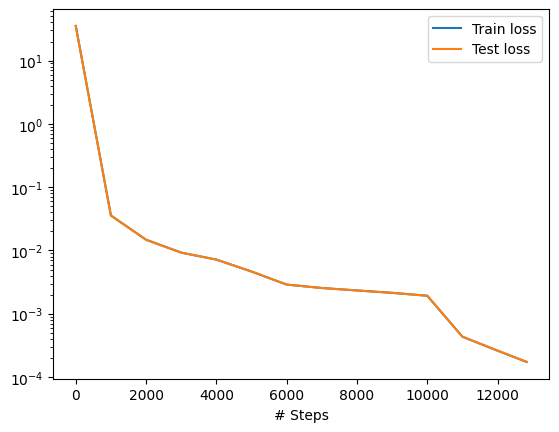

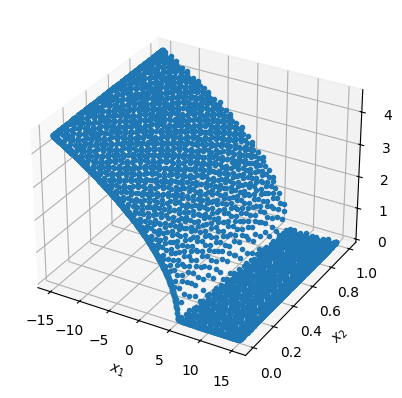

In [67]:
dde.saveplot(losshistory, train_state)

Text(0.5, 1.0, 'Original solution')

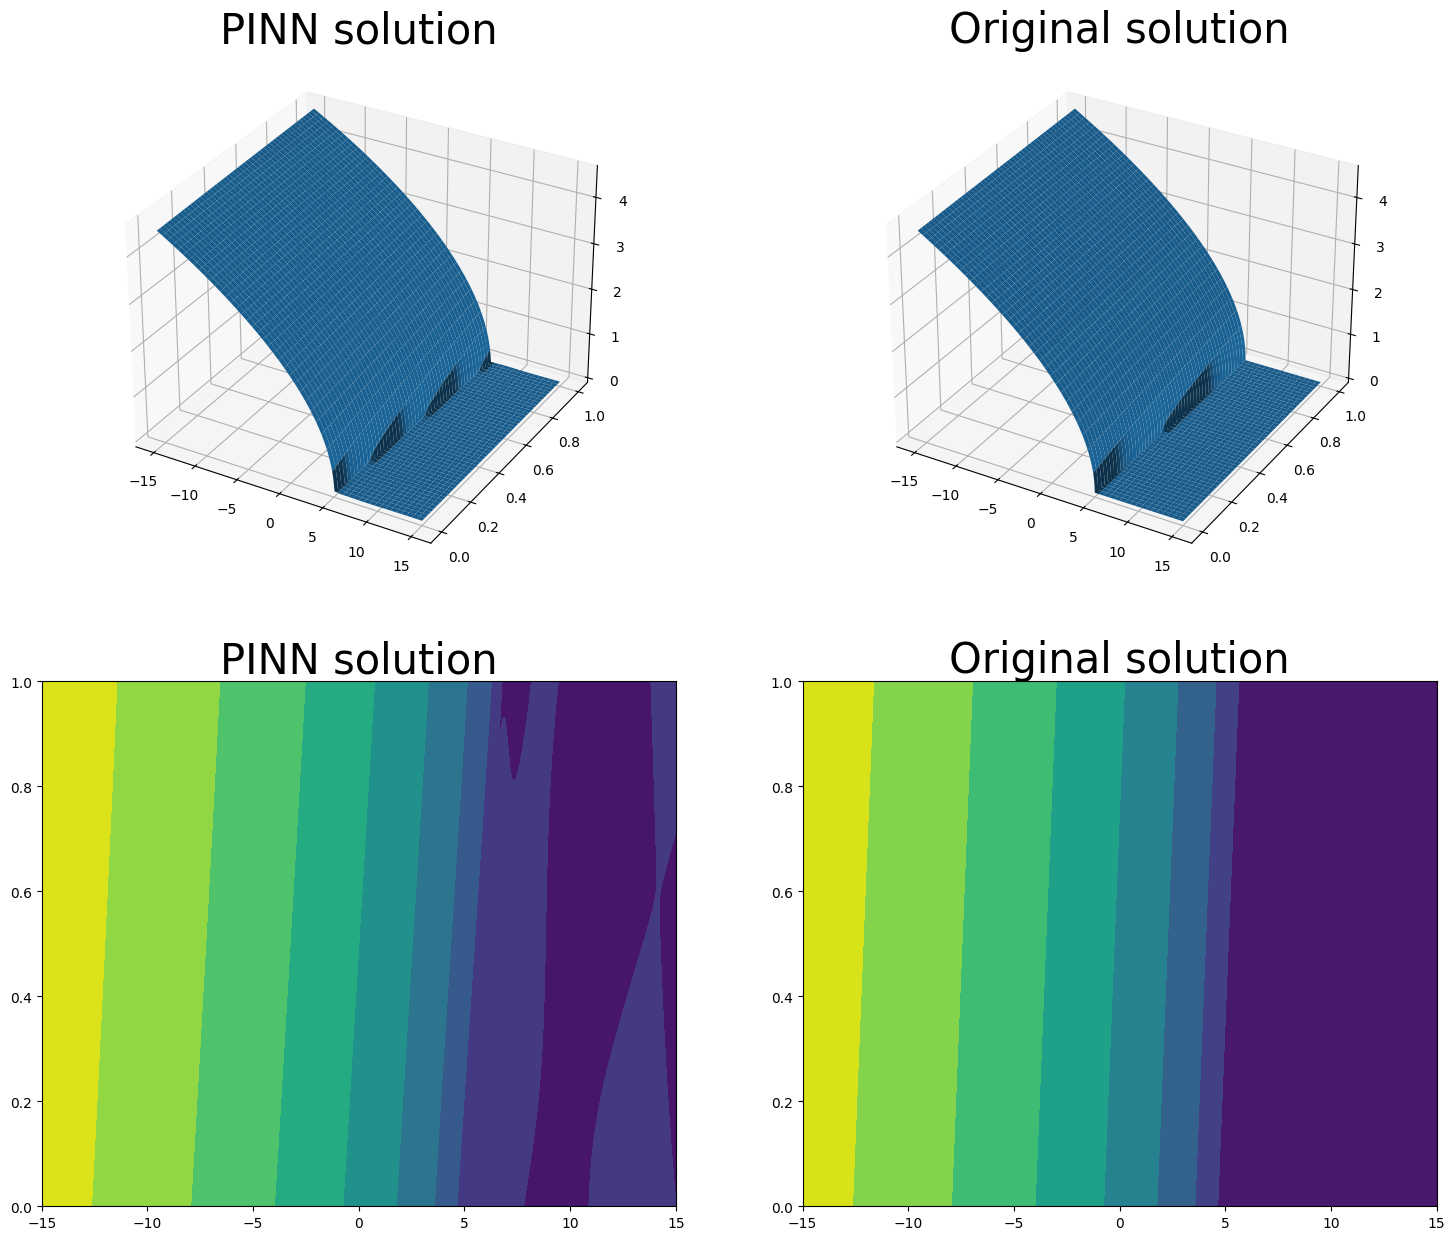

In [68]:
    

n_x   = 1000
n_t   = 1000


x_vals   = np.linspace(-L, L, n_x)    
t_vals   = np.linspace(t0, T, n_t)      
X, T_grid = np.meshgrid(x_vals, t_vals)
XT       = np.vstack((X.ravel(), T_grid.ravel())).T

U_pinn   = model.predict(XT).reshape(n_t, n_x)

U_bar    = solution(X, T_grid, m, D,E)

U_diff   = np.abs(U_pinn - U_bar)

fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(2,2,1, projection = '3d')
ax.plot_surface(X,T_grid,U_pinn)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,2, projection = '3d')
ax.plot_surface(X,T_grid,U_bar)
ax.set_title('Original solution',fontsize = 30)


ax = fig.add_subplot(2,2,3)
ax.contourf(X,T_grid,U_pinn)
ax.set_title('PINN solution',fontsize=30)

ax = fig.add_subplot(2,2,4)
ax.contourf(X,T_grid,U_bar)
ax.set_title('Original solution',fontsize = 30)


In [69]:

import pandas as pd

data = {'X':XT[:,0], 'T':XT[:,1], 'U':model.predict(XT).T[0]}

df = pd.DataFrame(data)
#df.to_csv('50x4_10000x500x500_m=05_PINN.csv')
